# Visualisation Tools for Active Learning Results

In [83]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pymongo import MongoClient
import yaml
import sys, traceback

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [70]:
# Connect to mongodb collection
path = r'../conn_config.yaml'
with open(path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
collection_name = 'experiments'

try:
    cluster = MongoClient(config['Mongo']['uri'])
    db = cluster[config['Mongo']['db']]
    collection = db[collection_name]
except:
    traceback.print_exc(file=sys.stdout)

In [71]:
uid = '2a40723d-1ad1-4d88-b534-bd6a32f88a74'

In [72]:
data = collection.find_one({'_id': uid})

In [96]:
task_type = data["settings"]["Utils"]["task_type"]

## Preprocess data

Pre-process results of training cycles for different active learning routines.

In [74]:
# Unstack each data split
splits = list(data['results'][list(data['results'].keys())[0]])
split_results = {split: [] for split in splits}

for split in splits:
    for run in data['results'].keys():
        split_results[split].append(data['results'][run][split]["f1 macro"])

In [116]:
split_results['30']

[0.9254624073097635,
 0.928132677022679,
 0.9159538887286933,
 0.9261014598547357,
 0.9266936199049287]

In [76]:
# Get statistics of runs
split_stats = dict()
for split in splits:
    split_stats[split] = dict()
    split_stats[split]['mean'] = np.mean(split_results[split])
    split_stats[split]['q1'] = np.quantile(split_results[split], 0.25)
    split_stats[split]['q3'] = np.quantile(split_results[split], 0.75)

In [78]:
# Convert split int into str with % suffix
x = [f'{float(k):0.0f}%' for k in split_stats.keys()]

In [79]:
y_mean = [v["mean"]*100 for k, v in split_stats.items()]
y_q1 = [v["q1"]*100 for k, v in split_stats.items()]
y_q3 = [v["q3"]*100 for k, v in split_stats.items()]

In [94]:
print("\n".join([f'Sample {idx}: {mean:0.2f}%' for idx, mean in enumerate(y_mean)]))

Sample 0: 92.54%
Sample 1: 92.38%
Sample 2: 92.45%
Sample 3: 92.68%
Sample 4: 92.63%
Sample 5: 92.67%
Sample 6: 92.68%
Sample 7: 92.63%
Sample 8: 92.65%


In [114]:
# Get full data performance
uid_fdp = '00b6f6c0-2e54-4e18-bc4f-c0151c2f4172'
data_fdp = collection.find_one({'_id': uid_fdp})
# print(data_fdp)
fdp_mean = np.mean([result for run, result in data_fdp['results'].items()])*100
fdp_mean

92.63327529735201

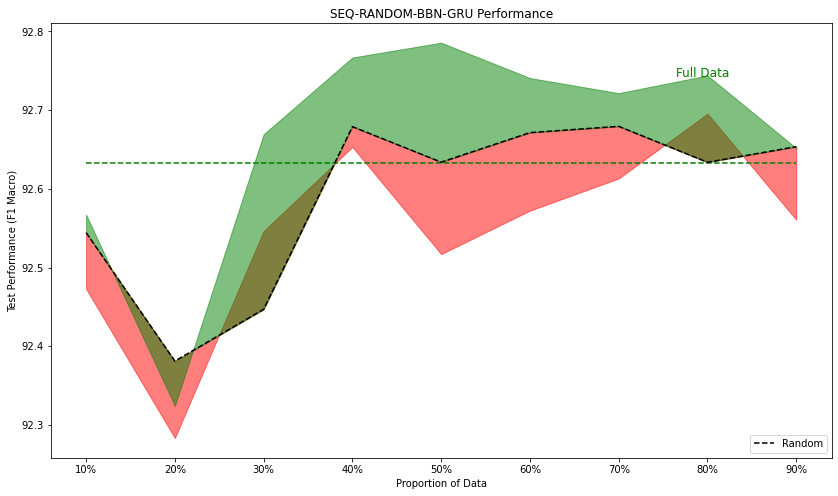

In [115]:
fig, ax = plt.subplots()

plt.plot(x, y_mean, color='black', linestyle='dashed')
plt.fill_between(x, y_q1, y_mean, alpha=0.5, color='red')
plt.fill_between(x, y_mean, y_q3, alpha=0.5, color='green')

plt.title(f'{task_type.upper()}-{data["settings"]["Train"]["al_mode"].upper()}-{data["settings"]["Utils"][task_type]["data_name"].upper()}-{data["settings"]["Models"]["TaskLearner"]["Parameters"]["rnn_type"].upper()} Performance')
plt.xlabel('Proportion of Data')
plt.ylabel('Test Performance (F1 Macro)')
plt.legend(['Random'], loc='lower right')
plt.hlines(y=fdp_mean, xmin=min(x), xmax=max(x), linestyle='dashed', color='green')
props = dict(boxstyle='square', facecolor='white', alpha=0.5)
plt.text(0.8, 0.9, 'Full Data', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='green')

plt.show()